In [ ]:
# --- CELL 1: INSTALLATION ---
# Run this once to set up the environment
#pip install networkx matplotlib google-generativeai gTTS

# --- CELL 2: IMPORTS & SETUP ---
import networkx as nx
import matplotlib.pyplot as plt
import json
import base64
from io import BytesIO
from gtts import gTTS
from IPython.display import HTML, display



In [ ]:
# ==========================================
# 🕒 HOUR 1: THE FOUNDATION (The Map)
# ==========================================

# 1. Define Nodes (Approximate X,Y coordinates based on USF Map)
locations = {
    "Marshall Student Center": (0, 0),
    "USF Library": (0, -2),
    "Bookstore": (-1, 0),
    "Student Services (SVC)": (-1, -1),
    "Chemistry (CHE)": (-2, -1),
    "Interdisciplinary Science (ISA)": (-2, -2),
    "Engineering (ENB)": (3, 0),
    "Engineering II (ENC)": (3.2, 0.5),
    "Muma College of Business": (2, -3),
    "Education (EDU)": (1, -1),
    "Cooper Hall (CPR)": (1, -2),
    "Yuengling Center": (5, -1),
    "Recreation Center": (4, 1),
    "Juniper-Poplar Hall": (1, 3),
    "Castor Hall": (0, 2),
    "Fine Arts (FAH)": (-1, 1),
    "Botanical Gardens": (-3, -4),
    "USF Health (MDC)": (-4, 2),
    "Beard Parking Garage": (3, 2),
    "Collins Blvd Parking": (0, -3),
    # additional places
    "Research Park": (-1, 5),
    "The FIT": (1, 5),
    "Baseball Field": (5, 1.5),
    "Honors College": (3, -1)
}

# 2. Define Edges
edges = [
    ("Marshall Student Center", "Castor Hall", 3),
    ("Marshall Student Center", "Bookstore", 2),
    ("Marshall Student Center", "Student Services (SVC)", 2),
    ("Marshall Student Center", "Engineering (ENB)", 6),
    ("Marshall Student Center", "USF Library", 5),
    ("Marshall Student Center", "Fine Arts (FAH)", 3),
    ("Castor Hall", "Juniper-Poplar Hall", 4),
    ("Juniper-Poplar Hall", "Beard Parking Garage", 5),
    ("Beard Parking Garage", "Engineering (ENB)", 4),
    ("Engineering (ENB)", "Engineering II (ENC)", 1),
    ("Engineering (ENB)", "Recreation Center", 3),
    ("Engineering (ENB)", "Education (EDU)", 4),
    ("Recreation Center", "Yuengling Center", 6),
    ("Yuengling Center", "Muma College of Business", 8),
    ("Muma College of Business", "Cooper Hall (CPR)", 3),
    ("Muma College of Business", "Collins Blvd Parking", 2),
    ("USF Library", "Cooper Hall (CPR)", 2),
    ("USF Library", "Student Services (SVC)", 3),
    ("USF Library", "Collins Blvd Parking", 2),
    ("USF Library", "Interdisciplinary Science (ISA)", 4),
    ("Student Services (SVC)", "Bookstore", 1),
    ("Bookstore", "Chemistry (CHE)", 3),
    ("Chemistry (CHE)", "Interdisciplinary Science (ISA)", 2),
    ("Chemistry (CHE)", "USF Health (MDC)", 6),
    ("Interdisciplinary Science (ISA)", "Botanical Gardens", 8),
    ("Fine Arts (FAH)", "Bookstore", 2),
    ("USF Health (MDC)", "Fine Arts (FAH)", 5),

    #new edges:
    ("Research Park", "The FIT", 4),           # Horizontal path top campus
    ("Research Park", "USF Health (MDC)", 6),  # Diagonal down-left
    ("Research Park", "Juniper-Poplar Hall", 5), # Diagonal down-right
    ("Research Park", "Castor Hall", 6),       # Long vertical
    ("The FIT", "Juniper-Poplar Hall", 3),     # Vertical short
    ("The FIT", "Beard Parking Garage", 5),    # Diagonal
    ("The FIT", "Castor Hall", 6),
    ("Baseball Field", "Recreation Center", 2),
    ("Baseball Field", "Yuengling Center", 4),
    ("Baseball Field", "Engineering II (ENC)", 3),
    ("Baseball Field", "Beard Parking Garage", 4),

    # Densifying Core Campus (Shortcuts)
    ("USF Library", "Education (EDU)", 3),
    ("USF Library", "Muma College of Business", 4),
    ("USF Library", "Honors College", 4),
    ("USF Library", "Bookstore", 3),
    ("Student Services (SVC)", "Education (EDU)", 3),
    ("Student Services (SVC)", "Fine Arts (FAH)", 3),
    ("Student Services (SVC)", "Cooper Hall (CPR)", 3),
    ("Chemistry (CHE)", "Fine Arts (FAH)", 3),
    ("Chemistry (CHE)", "Botanical Gardens", 5),
    ("Interdisciplinary Science (ISA)", "Collins Blvd Parking", 3),
    ("Interdisciplinary Science (ISA)", "Muma College of Business", 5),

    # Engineering & East Campus Shortcuts
    ("Engineering (ENB)", "Yuengling Center", 5),
    ("Engineering (ENB)", "Juniper-Poplar Hall", 6),
    ("Engineering (ENB)", "Baseball Field", 4),
    ("Engineering II (ENC)", "Recreation Center", 2),
    ("Engineering II (ENC)", "Beard Parking Garage", 3),

    # South Campus Connectivity
    ("Education (EDU)", "Muma College of Business", 3),
    ("Education (EDU)", "Castor Hall", 5),
    ("Cooper Hall (CPR)", "Muma College of Business", 2),
    ("Cooper Hall (CPR)", "Collins Blvd Parking", 3),
    ("Cooper Hall (CPR)", "Marshall Student Center", 4),

    # North-West & Health Connectivity
    ("Fine Arts (FAH)", "Castor Hall", 4),
    ("Fine Arts (FAH)", "USF Health (MDC)", 4),
    ("USF Health (MDC)", "Botanical Gardens", 9),

    # North-East Connectivity
    ("Beard Parking Garage", "Recreation Center", 2),
    ("Beard Parking Garage", "Yuengling Center", 5),
    ("Juniper-Poplar Hall", "Recreation Center", 5),
    ("Castor Hall", "Beard Parking Garage", 5),
    ("Castor Hall", "Bookstore", 4),

    # Central Hub Shortcuts
    ("Marshall Student Center", "Education (EDU)", 3),
    ("Marshall Student Center", "Cooper Hall (CPR)", 4),
    ("Marshall Student Center", "Juniper-Poplar Hall", 5),
    ("Marshall Student Center", "Recreation Center", 7)

]

# 3. Build Graph
G = nx.Graph()
for node, pos in locations.items():
    G.add_node(node, pos=pos)
G.add_weighted_edges_from([(u, v, w) for u, v, w in edges])
print(f"✅ Map Built: {G.number_of_nodes()} Locations, {G.number_of_edges()} Paths.")

# 4. Amenities Dictionary: holds which locations have which amenities
# Ex: Honors has a coffee shop
AMENITIES =  {   # Core hubs
    "Marshall Student Center": [
        "food", "foodcourt", "dining", "coffee", "microwave", "Chic-fil-a",
        "study", "lounges", "hangout", "events", "student-life", "Sushi", "Panera", "printer"
    ],  # MSC has a food court + restaurants + Starbucks + study lounges :contentReference[oaicite:0]{index=0}

    "USF Library": [
        "study", "quiet", "group-study", "study-rooms",
        "printers", "snacks", "coffee", "starbucks", "Vending Machine"
    ],  # Library has many study spaces/rooms + Starbucks in library :contentReference[oaicite:1]{index=1}

    "Bookstore": [
        "coffee", "kahwa", "snacks", "shop", "supplies"
    ],  # Kahwa Coffee café inside Tampa bookstore :contentReference[oaicite:2]{index=2}

    "Honors College": [
        "coffee", "buddy-brew", "study", "quiet", "collaboration",
        "creative-spaces", "events"
    ],  # Honors building has Buddy Brew café + “study pods”/collab spaces :contentReference[oaicite:3]{index=3}


    # Student services / admin
    "Student Services (SVC)": [
        "advising", "financial-aid", "registrar", "student-services", "offices"
    ],  # Primarily admin/student support offices

    # STEM academic buildings
    "Chemistry (CHE)": [
        "classes", "labs", "science",
    ],

    "Interdisciplinary Science (ISA)": [
        "classes", "labs", "science", "study"
    ],

    "Engineering (ENB)": [
        "classes", "engineering", "study", "ENB", "fishbowl", "microwave", "printer"
    ],

    "Engineering II (ENC)": [
        "classes", "labs", "engineering", "study", "engineering-student-services", "advising"
    ],  # ENC houses Engineering Student Services + departments :contentReference[oaicite:4]{index=4}


    # Other academic buildings
    "Muma College of Business": [
        "classes", "business", "study", "advising", "career-services", "food", "boba", "Rocky's Hideaway"
    ],

    "Education (EDU)": [
        "classes", "education", "study", "advising"
    ],

    "Cooper Hall (CPR)": [
        "classes", "Subway", "food", "arts-sciences", "Vending Machine"
    ],

    "Fine Arts (FAH)": [
        "classes", "arts", "studios", "galleries"
    ],


    # Recreation / sports
    "Recreation Center": [
        "gym", "workout", "fitness class", "basketball", "weights", "recreation"
    ],  # RecWell main gym facility :contentReference[oaicite:5]{index=5}

    "The FIT": [
        "gym", "workout", "fitness", "wellness", "pool", "recreation"
    ],  # FIT is a RecWell satellite gym w/ pool :contentReference[oaicite:6]{index=6}

    "Yuengling Center": [
        "arena", "events", "sports", "basketball", "concerts", "concessions"
    ],  # Arena has concessions/arena dining during events :contentReference[oaicite:7]{index=7}

    "Baseball Field": [
        "sports", "baseball", "events", "games"
    ],


    # Residence halls
    "Juniper-Poplar Hall": [
        "dorm", "housing", "dining-hall", "food", "coffee",
        "study", "lounges", "community", "Vending Machine"
    ],  # JPH includes dining hall + study lounges + Starbucks (per housing/oracle) :contentReference[oaicite:8]{index=8}

    "Castor Hall": [
        "dorm", "housing", "study", "lounges", "near-dining"
    ],  # Castor has study lounges; dining hall nearby :contentReference[oaicite:9]{index=9}


    # Outdoors / nature
    "Botanical Gardens": [
        "outdoors", "nature", "walk", "relax", "quiet", "scenic"
    ],  # Gardens are a quiet outdoor campus attraction :contentReference[oaicite:10]{index=10}


    # Health campus
    "USF Health (MDC)": [
        "health", "medical", "classes", "labs", "clinics", "study", "offices"
    ],


    # Parking nodes
    "Beard Parking Garage": [
        "parking", "garage"
    ],
    "Collins Blvd Parking": [
        "parking", "lot"
    ],


    # Research / office area
    "Research Park": [
        "research", "labs", "offices", "innovation", "startups"
    ],  # Research Park = lab/office/research hub :contentReference[oaicite:11]{index=11}
}

✅ Map Built: 24 Locations, 68 Paths.


In [ ]:
# ==========================================
# 🕒 HOUR 2: THE BRAIN (The LLM)
# ==========================================

# System Prompt: Defines the "Rules" for the AI
import os
from google.colab import userdata
import google.generativeai as genai

# 1. Load and VERIFY the API key
try:
    api_key = userdata.get('GEMINI_API_KEY')

    # Debug: Check if key was retrieved
    if api_key:
        print(f"✅ API Key retrieved: {api_key[:10]}...{api_key[-4:]}")  # Show first/last chars
        print(f"   Key length: {len(api_key)} characters")
    else:
        print("❌ ERROR: API key is None or empty!")

    os.environ['GEMINI_API_KEY'] = api_key

except Exception as e:
    print(f"❌ ERROR retrieving API key: {e}")
    api_key = None

# 2. Configure Gemini
if api_key:
    try:
        genai.configure(api_key=api_key)
        print("✅ Gemini configured successfully.")
    except Exception as e:
        print(f"❌ ERROR: Gemini configuration failed: {e}")
else:
    print("❌ Cannot configure Gemini - no API key available")

SYSTEM_PROMPT = f"""
You are the navigation brain for USF SmartNav.
Your Job: Convert user text into a structured JSON object.
The user will tell you where they are and what they want.
You must map their vague request to the CLOSEST logical node from this list:
{list(locations.keys())}

Use these campus amenities to map vague intents:
{AMENITIES}

Rules:

If the start is unknown, default to "Marshall Student Center".
If the destination is vague (e.g. "food"), pick the most logical node (e.g. "Marshall Student Center" or "Bookstore").
If they mention a class code like "ENC", map it to "Engineering II (ENC)".
Return ONLY JSON. No markdown formatting.
Output Format:
{{
"start_node": "Exact Node Name",
"target_node": "Exact Node Name",
"reasoning": "Brief explanation of why you picked this target"
}}
"""
# Client is already configured from the key implementation step
# We can now create the model instance
model = genai.GenerativeModel('gemini-2.0-flash', system_instruction=SYSTEM_PROMPT)

def get_navigation_intent(user_query):
    """Sends query to Gemini and parses JSON response"""
    try:
        response = model.generate_content(user_query)
        # Clean response (sometimes models add ```json ... ```)
        clean_text = response.text.replace("```json", "").replace("```", "").strip()
        return json.loads(clean_text)
    except Exception as e:
        print(f"❌ AI Error: {e}")
        return None
# # TEST 1
# # --- TEST THE AI ---
# user_test_query = "I'm near the gym and need to get to my Engineering class ASAP!"
# print(f"\n🧠 Sending query to AI: '{user_test_query}'")
# intent = get_navigation_intent(user_test_query)
# print("\n--- AI Structured Intent ---")
# print(json.dumps(intent, indent=4))

# TEST 2
# # --- TEST THE AI ---
# user_test_query = "I'm at honors building and I want to get coffee what are my options!"
# print(f"\n🧠 Sending query to AI: '{user_test_query}'")
# intent = get_navigation_intent(user_test_query)
# print("\n--- AI Structured Intent ---")
# print(json.dumps(intent, indent=4))

# # --- TEST THE AI ---
# user_test_query = "I'm at honors building and I want to get food what are my options!"
# print(f"\n🧠 Sending query to AI: '{user_test_query}'")
# intent = get_navigation_intent(user_test_query)
# print("\n--- AI Structured Intent ---")
# print(json.dumps(intent, indent=4))
# --- END AI TEST ---


✅ API Key retrieved: AIzaSyB5Jl...ei6s
   Key length: 39 characters
✅ Gemini configured successfully.


In [ ]:
# ==========================================
# 🕒 HOUR 3: THE VISUALIZATION
# ==========================================

def visualize_campus_path(start_node, target_node):
    try:
        path = nx.shortest_path(G, source=start_node, target=target_node, weight="weight")
        path_edges = list(zip(path, path[1:]))
    except nx.NetworkXNoPath:
        return None

    # Determine strict bounding box of the path to "zoom in"
    xs = [locations[n][0] for n in path]
    ys = [locations[n][1] for n in path]

    plt.figure(figsize=(8, 6), facecolor='white')
    pos = nx.get_node_attributes(G, 'pos')

    # Draw simplified graph
    nx.draw_networkx_nodes(G, pos, node_color='#e2e8f0', node_size=300)
    nx.draw_networkx_edges(G, pos, edge_color='#e2e8f0', width=1)

    # Highlight Path
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_color='#006747', node_size=500)
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='#006747', width=4)

    # Labels
    labels = {n: n for n in path} # Only label the path
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_weight='bold')

    plt.axis('off')

    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', dpi=100)
    plt.close()
    buf.seek(0)
    return base64.b64encode(buf.read()).decode('utf-8')

In [ ]:
# ==========================================
# 🕒 HOUR 4: INTEGRATION & UI (The "SmartNav" App)
# ==========================================

def text_to_audio_base64(text_input):
    """Generates MP3 audio and returns Base64 string"""
    try:
        tts = gTTS(text=text_input, lang='en', slow=False)
        fp = BytesIO()
        tts.write_to_fp(fp)
        fp.seek(0)
        return base64.b64encode(fp.read()).decode('utf-8')
    except:
        return ""

def generate_smartnav_interface(start, target, reasoning, graph_b64):
    """
    Generates a single HTML file combining:
    1. Your Friend's Design (React -> HTML/Tailwind Port)
    2. The Python Data (Graph, Audio, Routes)
    """

    # 1. Generate Audio Narrative
    narrative = f"Okay, I found a spot for you. Based on your request, we are heading to {target} from {start}. {reasoning}. Follow the green path shown on the graph."
    audio_b64 = text_to_audio_base64(narrative)

    # 2. HTML Template (Ported from React components)
    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Bulls Path</title>
        <script src="https://cdn.tailwindcss.com"></script>
        <!-- Icons -->
        <script src="https://unpkg.com/lucide@latest"></script>
        <style>
            @import url('https://fonts.googleapis.com/css2?family=Inter:wght@400;600;700&display=swap');
            body {{ font-family: 'Inter', sans-serif; }}
            /* USF Gradient Animation */
            .usf-gradient {{
                background: linear-gradient(135deg, #006747 0%, #008056 50%, #005a3c 100%);
            }}
        </style>
    </head>
    <body class="bg-gray-50 min-h-screen flex flex-col">

        <!-- HEADER (From Header.tsx) -->
        <header class="w-full bg-[#006747] border-b-2 border-[#CFC493] shadow-sm z-50 relative">
            <div class="max-w-7xl mx-auto px-4 h-16 flex items-center justify-between">
                <div class="flex items-center gap-3">
                    <div class="w-10 h-10 rounded-full bg-white/90 flex items-center justify-center shadow-md">
                        <i data-lucide="navigation" class="text-[#006747] w-5 h-5"></i>
                    </div>
                    <div class="flex flex-col">
                        <h1 class="text-white font-bold leading-tight">Bulls Path</h1>
                        <p class="text-[#CFC493] text-xs hidden sm:block">The AI Companion for New Students</p>
                    </div>
                </div>
                <button onclick="alert('Project for USF Hackathon Track 2')" class="text-white hover:text-[#CFC493] flex items-center gap-2">
                    <i data-lucide="info" class="w-5 h-5"></i>
                    <span class="hidden sm:inline">About</span>
                </button>
            </div>
        </header>

        <!-- HERO BACKGROUND (From HeroBackground.tsx) -->
        <div class="relative flex-1 flex flex-col">
            <!-- Background Layers -->
            <div class="absolute inset-0 usf-gradient z-0"></div>
            <div class="absolute inset-0 opacity-10 z-0" style="background-image: radial-gradient(#CFC493 1px, transparent 1px); background-size: 20px 20px;"></div>

            <!-- MAIN CONTENT CONTAINER -->
            <main class="relative z-10 w-full max-w-5xl mx-auto px-4 py-8 flex flex-col md:flex-row gap-6 h-full">

                <!-- LEFT COLUMN: Input & Audio -->
                <div class="w-full md:w-1/3 flex flex-col gap-6">

                    <!-- INPUT SECTION (From InputSection.tsx - Compact Mode) -->
                    <div class="bg-white rounded-xl shadow-xl p-6 border border-white/20 backdrop-blur-sm">
                        <div class="space-y-4">
                            <div>
                                <label class="block text-sm text-gray-600 font-medium mb-1">Current Location</label>
                                <div class="flex gap-2">
                                    <input type="text" value="{start}" disabled class="flex-1 bg-gray-50 border border-gray-200 rounded-lg px-3 py-2 text-sm text-gray-800 font-semibold">
                                    <button class="p-2 text-[#006747] bg-[#e6f2ed] rounded-lg">
                                        <i data-lucide="map-pin" class="w-4 h-4"></i>
                                    </button>
                                </div>
                            </div>
                            <div>
                                <label class="block text-sm text-gray-600 font-medium mb-1">Destination</label>
                                <input type="text" value="{target}" disabled class="w-full bg-gray-50 border border-gray-200 rounded-lg px-3 py-2 text-sm text-gray-800 font-semibold">
                            </div>
                            <div class="text-xs text-gray-500 italic border-l-2 border-[#CFC493] pl-2">
                                "{reasoning}"
                            </div>
                        </div>
                    </div>

                    <!-- AUDIO PLAYER (From AudioGuidePlayer.tsx) -->
                    <div class="bg-gradient-to-r from-[#e6f2ed] to-[#f5f1e6] rounded-xl p-5 border border-[#CFC493]/30 shadow-md">
                        <div class="flex items-center gap-2 mb-3 text-[#006747] font-bold">
                            <i data-lucide="volume-2" class="w-5 h-5"></i>
                            <h4>Audio Guide</h4>
                        </div>
                        <audio id="audioPlayer" class="w-full mb-2" controls src="data:audio/mp3;base64,{audio_b64}"></audio>
                        <p class="text-xs text-gray-600 text-center">Auto-generated navigation guide</p>
                    </div>
                </div>

                <!-- RIGHT COLUMN: Graph View (From GraphView.tsx) -->
                <div class="w-full md:w-2/3 bg-white rounded-xl shadow-2xl overflow-hidden flex flex-col min-h-[400px]">
                    <!-- TABS -->
                    <div class="flex border-b border-gray-200 bg-gray-50">
                        <button onclick="switchTab('graph')" id="tab-graph" class="flex-1 py-3 text-sm font-medium text-center bg-[#006747] text-white transition-colors">
                            Graph View
                        </button>
                        <button onclick="switchTab('map')" id="tab-map" class="flex-1 py-3 text-sm font-medium text-center text-gray-500 hover:text-[#006747] transition-colors">
                            Map View (Preview)
                        </button>
                    </div>

                    <!-- CONTENT AREA -->
                    <div class="flex-1 relative bg-white p-4 flex items-center justify-center">

                        <!-- GRAPH CONTENT -->
                        <div id="content-graph" class="w-full h-full flex flex-col items-center justify-center">
                            <img src="data:image/png;base64,{graph_b64}" class="max-h-[400px] object-contain rounded-lg shadow-sm border border-gray-100" alt="Graph Path">
                            <div class="mt-4 flex items-center gap-2 text-sm text-gray-500">
                                <span class="w-3 h-3 rounded-full bg-[#006747]"></span> Route Path
                                <span class="w-3 h-3 rounded-full bg-gray-300 ml-2"></span> Nodes
                            </div>
                        </div>

                        <!-- MAP CONTENT (Placeholder for compatibility) -->
                        <div id="content-map" class="hidden w-full h-full flex flex-col items-center justify-center text-center p-8">
                             <div class="bg-gray-100 rounded-full p-6 mb-4">
                                <i data-lucide="map" class="w-10 h-10 text-gray-400"></i>
                             </div>
                             <h3 class="text-gray-700 font-semibold">Interactive Map Module</h3>
                             <p class="text-sm text-gray-500 max-w-xs mt-2">
                                The Canvas Map View requires the React Runtime.
                                <br>Displaying the Python-generated Graph View instead.
                             </p>
                        </div>

                    </div>
                </div>
            </main>
        </div>

        <script>
            // Initialize Icons
            lucide.createIcons();

            // Tab Switching Logic
            function switchTab(tabName) {{
                const graphBtn = document.getElementById('tab-graph');
                const mapBtn = document.getElementById('tab-map');
                const graphContent = document.getElementById('content-graph');
                const mapContent = document.getElementById('content-map');

                if (tabName === 'graph') {{
                    graphBtn.classList.add('bg-[#006747]', 'text-white');
                    graphBtn.classList.remove('text-gray-500');
                    mapBtn.classList.remove('bg-[#006747]', 'text-white');
                    mapBtn.classList.add('text-gray-500');

                    graphContent.classList.remove('hidden');
                    mapContent.classList.add('hidden');
                }} else {{
                    mapBtn.classList.add('bg-[#006747]', 'text-white');
                    mapBtn.classList.remove('text-gray-500');
                    graphBtn.classList.remove('bg-[#006747]', 'text-white');
                    graphBtn.classList.add('text-gray-500');

                    mapContent.classList.remove('hidden');
                    graphContent.classList.add('hidden');
                }}
            }}
        </script>
    </body>
    </html>
    """
    return html_content

In [ ]:
# TEST 1
# GYM
# --- TEST THE AI ---
user_test_query = "I'm near the gym and need to get to my Engineering class ASAP!"
print(f"\n🧠 Sending query to AI: '{user_test_query}'")
intent = get_navigation_intent(user_test_query)
print("\n--- AI Structured Intent ---")
print(json.dumps(intent, indent=4))


🧠 Sending query to AI: 'I'm near the gym and need to get to my Engineering class ASAP!'

--- AI Structured Intent ---
{
    "start_node": "Recreation Center",
    "target_node": "Engineering (ENB)",
    "reasoning": "The user is near the gym (Recreation Center or The FIT) and needs to get to their Engineering class which is most likely in the Engineering building."
}


In [ ]:
# # TEST 2
# # MICROWAVE
# --- TEST THE AI ---
user_test_query = "I'm at the library and I need to use a microwave!"
print(f"\n🧠 Sending query to AI: '{user_test_query}'")
intent = get_navigation_intent(user_test_query)
print("\n--- AI Structured Intent ---")
print(json.dumps(intent, indent=4))



🧠 Sending query to AI: 'I'm at the library and I need to use a microwave!'

--- AI Structured Intent ---
{
    "start_node": "USF Library",
    "target_node": "Marshall Student Center",
    "reasoning": "The Marshall Student Center is the most logical destination for using a microwave, as it has a food court."
}


In [ ]:

# TEST 3
# PRINT
# --- TEST THE AI ---
user_test_query = "I'm at cooper and I need to print something before my 10 AM class."
print(f"\n🧠 Sending query to AI: '{user_test_query}'")
intent = get_navigation_intent(user_test_query)
print("\n--- AI Structured Intent ---")
print(json.dumps(intent, indent=4))


🧠 Sending query to AI: 'I'm at cooper and I need to print something before my 10 AM class.'

--- AI Structured Intent ---
{
    "start_node": "Cooper Hall (CPR)",
    "target_node": "USF Library",
    "reasoning": "The USF Library is the closest location to Cooper Hall that has printers."
}


In [ ]:
# --- TEST THE AI ---
# COFFEE
user_test_query = "I'm at MUMA, but I want to get coffee in a quiet study space."
print(f"\n🧠 Sending query to AI: '{user_test_query}'")
intent = get_navigation_intent(user_test_query)
print("\n--- AI Structured Intent ---")
print(json.dumps(intent, indent=4))


🧠 Sending query to AI: 'I'm at MUMA, but I want to get coffee in a quiet study space.'

--- AI Structured Intent ---
{
    "start_node": "Muma College of Business",
    "target_node": "Honors College",
    "reasoning": "The Honors College is a quiet study space with coffee."
}


✅ Hour 4 Tasks Complete: UI Generated.



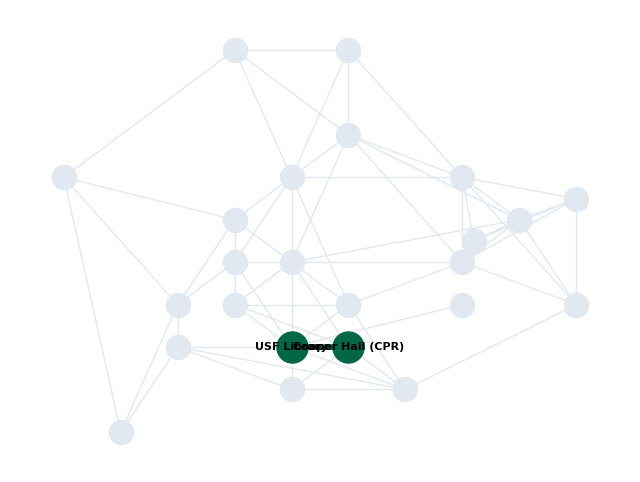

In [ ]:
# --- FINAL EXECUTION ---

# # 1. Simulate User Query (Since we might not have a live API key in this session)
# user_query = "I want coffee near the library"
# intent = get_navigation_intent(user_query)

# 2. Run Logic
start = intent['start_node']
target = intent['target_node']
reasoning = intent['reasoning']

# 3. Generate Assets
graph_b64 = visualize_campus_path(start, target)
html_output = generate_smartnav_interface(start, target, reasoning, graph_b64)

# 4. Display
print("✅ Hour 4 Tasks Complete: UI Generated.")
display(HTML(html_output))

# 5. Save to File (for download)
with open("smartnav_demo.html", "w") as f:
    f.write(html_output)